# Dataset Madera vs Metal

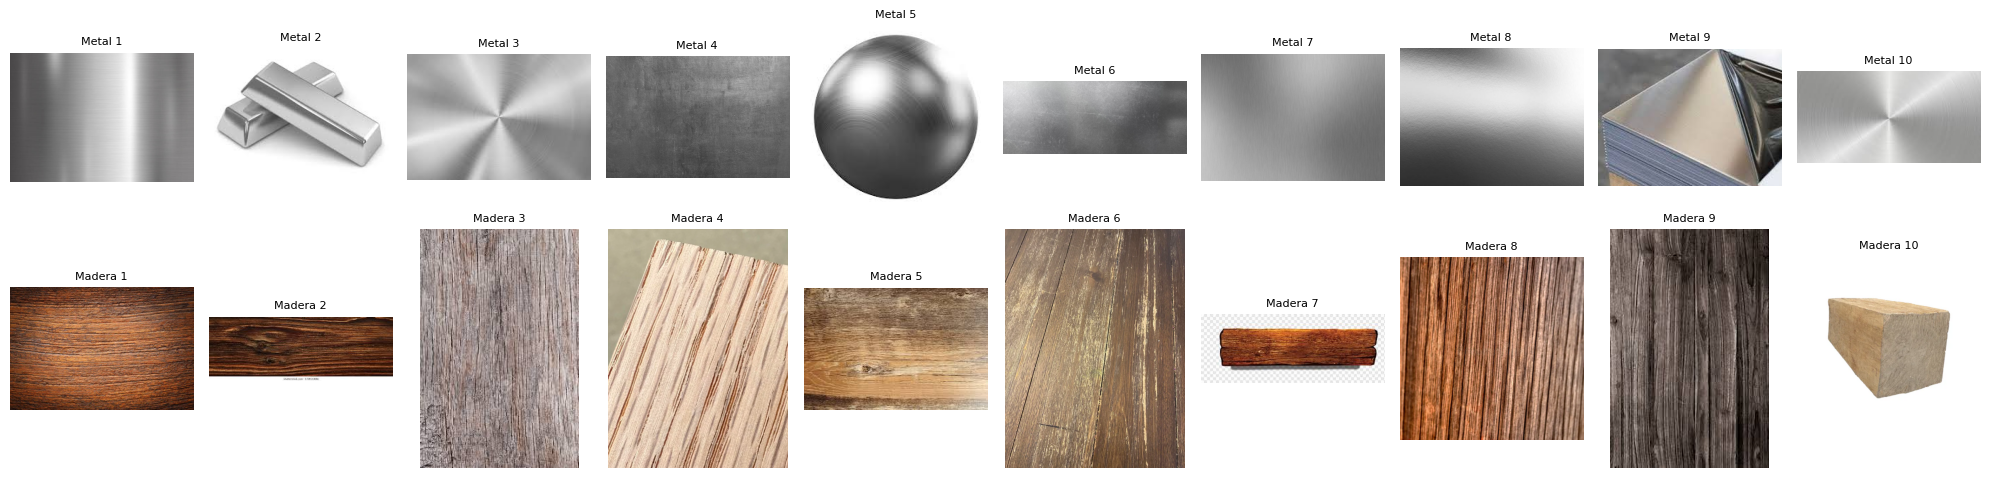

In [26]:
import matplotlib.pyplot as plt
import cv2

# Cambiamos a 2 filas (una para metal, otra madera) y 10 columnas
fig, axs = plt.subplots(2, 10, figsize=(20, 5)) 

# Procesar Metal (Fila 0)
for i in range(10):
    # i+1 para buscar archivos del 1 al 10
    img_metal = cv2.imread(f"./dataset/metal/{i+1}.jpg")
    if img_metal is not None:
        axs[0, i].imshow(cv2.cvtColor(img_metal, cv2.COLOR_BGR2RGB))
        axs[0, i].set_title(f"Metal {i+1}", fontsize=8)
    axs[0, i].axis('off')

# Procesar Madera (Fila 1)
for i in range(10):
    img_madera = cv2.imread(f"./dataset/madera/{i+1}.jpg")
    if img_madera is not None:
        axs[1, i].imshow(cv2.cvtColor(img_madera, cv2.COLOR_BGR2RGB))
        axs[1, i].set_title(f"Madera {i+1}", fontsize=8)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# Kernels

In [ ]:
#Kernels
laplaciano = np.array([
    [ 0, -1,  0],
    [-1,  4, -1],
    [ 0, -1,  0]
], dtype=np.float32)



sobel = np.array([
    [-1, 0,  1],
    [-2, 0,  2],
    [-1, 0,  1]
], dtype=np.float32)

# Analisis de dataset

In [27]:
import cv2
import numpy as np

# Kernels fundamentales
laplaciano = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)

def extraer_metricas(imagen):
    if len(imagen.shape) == 3:
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen = cv2.equalizeHist(imagen).astype(np.float32) / 255.0
    
    res_lap = cv2.filter2D(imagen, -1, laplaciano)
    res_sob = cv2.filter2D(imagen, -1, sobel)

    return [
        np.sum(np.abs(res_lap)) + np.sum(np.abs(res_sob)), # SUM
        np.var(res_lap) + np.var(res_sob),                 # VAR
        np.std(res_lap) + np.std(res_sob)                  # STD
    ]

def evaluar(ruta_metal, ruta_madera):
    met_vals = {"METAL": [], "MADERA": []}
    
    for cat, ruta in [("METAL", ruta_metal), ("MADERA", ruta_madera)]:
        for i in range(1, 11):
            img = cv2.imread(f"{ruta}/{i}.jpg")
            if img is not None:
                met_vals[cat].append(extraer_metricas(img))

    for i, nombre in enumerate(["SUMA", "VARIANZA", "STD"]):
        m_met = np.mean([x[i] for x in met_vals["METAL"]])
        m_mad = np.mean([x[i] for x in met_vals["MADERA"]])
        umbral = (m_met + m_mad) / 2
        print(f"{nombre} -> Metal: {m_met:.4f} | Madera: {m_mad:.4f} | Umbral Sugerido: {umbral:.4f}")

evaluar("./dataset/metal", "./dataset/madera")

SUMA -> Metal: 38403.0430 | Madera: 217669.7188 | Umbral Sugerido: 128036.3828
VARIANZA -> Metal: 0.1154 | Madera: 0.8741 | Umbral Sugerido: 0.4947
STD -> Metal: 0.3997 | Madera: 1.1405 | Umbral Sugerido: 0.7701



--- Evaluando METAL ---


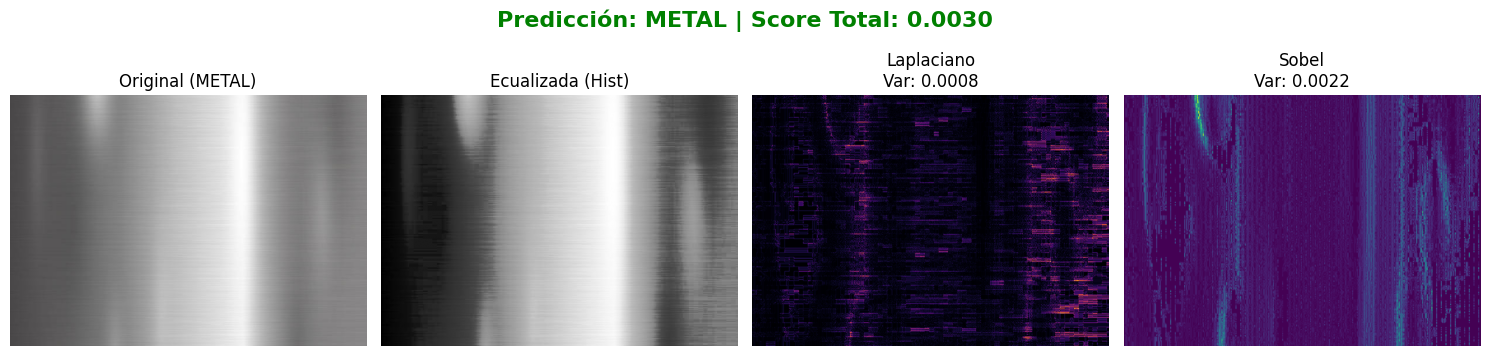

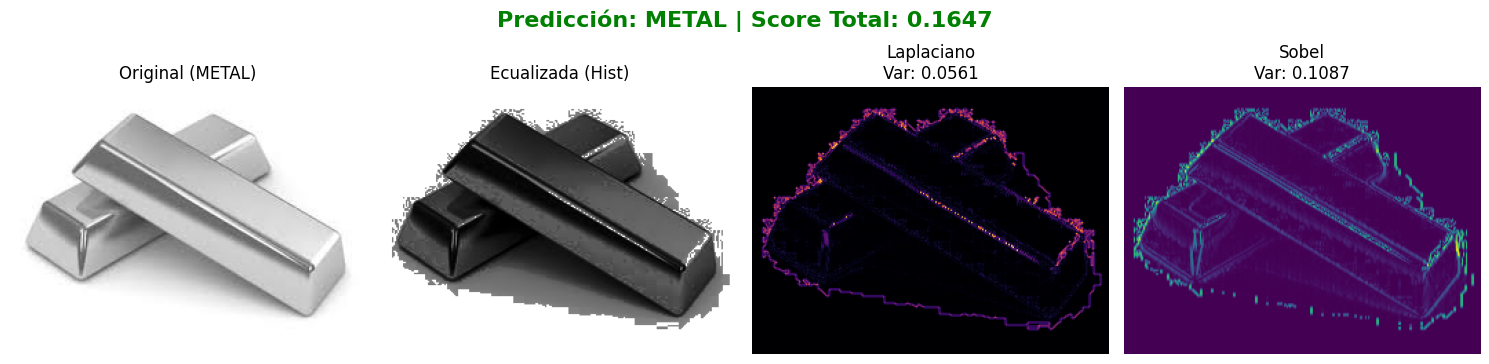


--- Evaluando MADERA ---


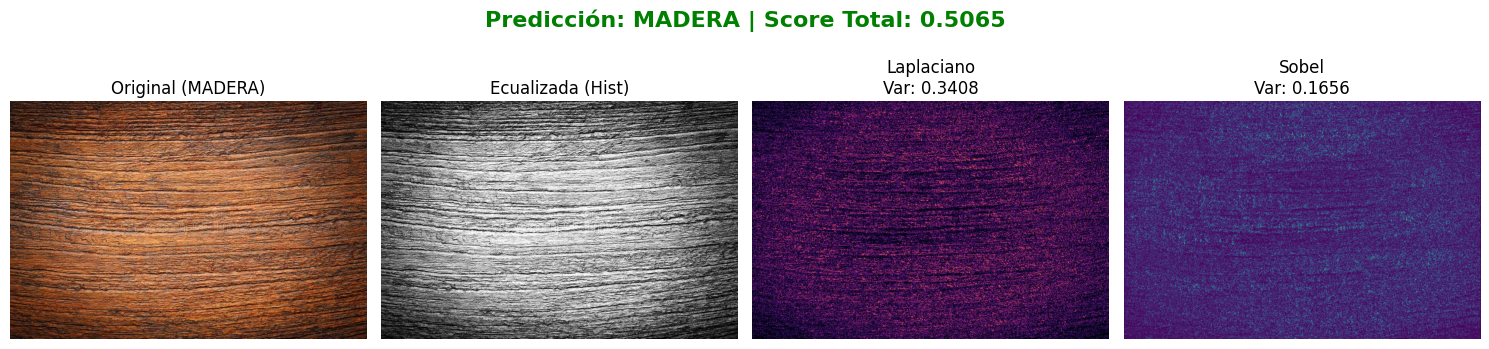

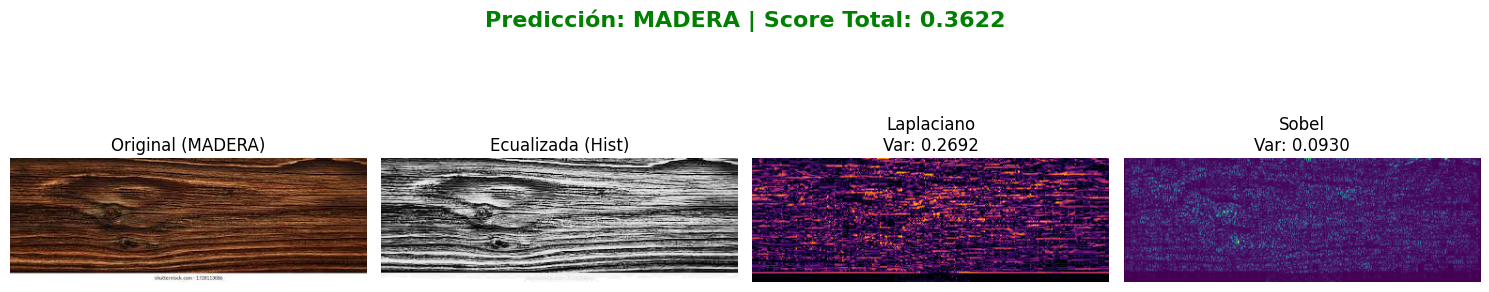

In [32]:
import matplotlib.pyplot as plt

def clasificar_y_graficar(ruta, etiqueta_real):
    img_bgr = cv2.imread(ruta)
    if img_bgr is None:
        return None, 0

    # 1. Pre-procesamiento
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_eq = cv2.equalizeHist(img_gray)
    img_float = img_eq.astype(np.float32) / 255.0

    # 2. Aplicar filtros
    res_lap = cv2.filter2D(img_float, -1, laplaciano)
    res_sob = cv2.filter2D(img_float, -1, sobel)

    # 3. Cálculo de Score (Usando Varianza como quedamos)
    score = np.var(res_lap) + np.var(res_sob)
    prediccion = "MADERA" if score > 0.25 else "METAL"
    es_correcto = prediccion == etiqueta_real

    # 4. Plotear resultados
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    
    # Imagen Original
    axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Original ({etiqueta_real})")
    
    # Imagen Ecualizada (lo que ve el algoritmo)
    axs[1].imshow(img_eq, cmap='gray')
    axs[1].set_title("Ecualizada (Hist)")
    
    # Respuesta Laplaciana (Textura fina)
    axs[2].imshow(np.abs(res_lap), cmap='inferno')
    axs[2].set_title(f"Laplaciano\nVar: {np.var(res_lap):.4f}")
    
    # Respuesta Sobel (Vetas/Líneas)
    axs[3].imshow(np.abs(res_sob), cmap='viridis')
    axs[3].set_title(f"Sobel\nVar: {np.var(res_sob):.4f}")

    color_titulo = 'green' if es_correcto else 'red'
    fig.suptitle(f"Predicción: {prediccion} | Score Total: {score:.4f}", 
                 fontsize=16, color=color_titulo, fontweight='bold')
    
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

    return prediccion, 1



for cat in ["metal", "madera"]:
    print(f"\n--- Evaluando {cat.upper()} ---")
    for i in range(1, 3): # Graficamos las primeras 5 de cada una para no saturar
        ruta = f"./dataset/{cat}/{i}.jpg"
        pred, t = clasificar_y_graficar(ruta, cat.upper())
        if pred:
            if pred == cat.upper(): correctos += 1
            total += 1



In [36]:
import cv2
import numpy as np

# 1. Función ligera solo para procesamiento (sin gráficas)
def clasificar_solo_texto(ruta_imagen):
    img = cv2.imread(ruta_imagen)
    if img is None:
        return None

    # Preprocesamiento (mismo que usaste antes)
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
        
    img_norm = cv2.equalizeHist(img_gray).astype(np.float32) / 255.0

    # Aplicar filtros (Asegúrate de tener definidos laplaciano y sobel)
    res_lap = cv2.filter2D(img_norm, -1, laplaciano)
    res_sob = cv2.filter2D(img_norm, -1, sobel)

    # Score basado en VARIANZA (o la métrica que hayas elegido)
    score = np.var(res_lap) + np.var(res_sob)

    # Umbral (Ajustado según tus pruebas anteriores)
    return "MADERA" if score > 0.25 else "METAL"

# 2. Evaluación del clasificador
correctos = 0
total = 0

print("=" * 50)
print("EVALUACIÓN DEL CLASIFICADOR (MODO TEXTO)")
print("=" * 50)

# Diccionario para simplificar los bucles
categorias = [("METAL", "./dataset/metal"), ("MADERA", "./dataset/madera")]

for etiqueta_real, carpeta in categorias:
    print(f"\n--- Probando imágenes de {etiqueta_real} ---")
    for i in range(1, 11):
        ruta = f"{carpeta}/{i}.jpg"
        prediccion = clasificar_solo_texto(ruta)
        
        if prediccion:
            es_correcto = prediccion == etiqueta_real
            check = "✓" if es_correcto else "✗"
            print(f"Imagen {etiqueta_real.lower()}/{i}.jpg: Predicción -> {prediccion:6} {check}")
            
            if es_correcto:
                correctos += 1
            total += 1

# 3. Resultados Finales
precision = (correctos / total) * 100 if total > 0 else 0
print("\n" + "=" * 50)
print(f"RESUMEN: {correctos}/{total} aciertos")
print(f"PRECISIÓN FINAL: {precision:.2f}%")
print("=" * 50)

EVALUACIÓN DEL CLASIFICADOR (MODO TEXTO)

--- Probando imágenes de METAL ---
Imagen metal/1.jpg: Predicción -> METAL  ✓
Imagen metal/2.jpg: Predicción -> METAL  ✓
Imagen metal/3.jpg: Predicción -> METAL  ✓
Imagen metal/4.jpg: Predicción -> MADERA ✗
Imagen metal/5.jpg: Predicción -> METAL  ✓
Imagen metal/6.jpg: Predicción -> METAL  ✓
Imagen metal/7.jpg: Predicción -> METAL  ✓
Imagen metal/8.jpg: Predicción -> METAL  ✓
Imagen metal/9.jpg: Predicción -> METAL  ✓
Imagen metal/10.jpg: Predicción -> METAL  ✓

--- Probando imágenes de MADERA ---
Imagen madera/1.jpg: Predicción -> MADERA ✓
Imagen madera/2.jpg: Predicción -> MADERA ✓
Imagen madera/3.jpg: Predicción -> MADERA ✓
Imagen madera/4.jpg: Predicción -> MADERA ✓
Imagen madera/5.jpg: Predicción -> MADERA ✓
Imagen madera/6.jpg: Predicción -> MADERA ✓
Imagen madera/7.jpg: Predicción -> MADERA ✓
Imagen madera/8.jpg: Predicción -> MADERA ✓
Imagen madera/9.jpg: Predicción -> MADERA ✓
Imagen madera/10.jpg: Predicción -> METAL  ✗

RESUMEN: 18/2

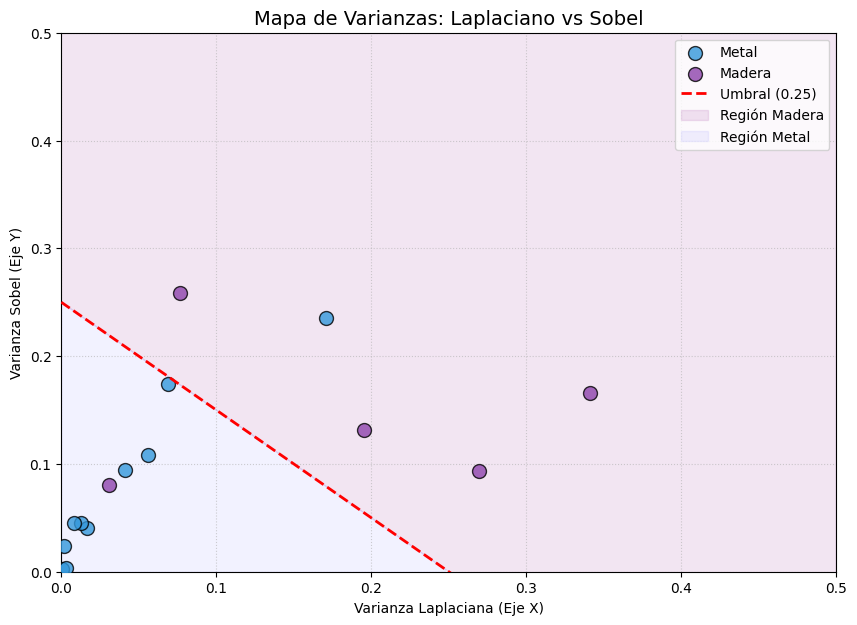

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



def procesar_y_obtener_varianzas(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ecualización para normalizar iluminación
    img = cv2.equalizeHist(img)
    img = img.astype(np.float32) / 255.0
    
    # Aplicar filtros
    resp1 = cv2.filter2D(img, -1, laplaciano)
    resp2 = cv2.filter2D(img, -1, sobel)
    
    # Retornar varianzas individuales (X, Y para el scatter)
    return np.var(resp1), np.var(resp2)

# --- 2. Recolección de Datos ---
varianzas = {"METAL": ([], []), "MADERA": ([], [])}

for cat, folder in [("METAL", "metal"), ("MADERA", "madera")]:
    for i in range(1, 11):
        img = cv2.imread(f"./dataset/{folder}/{i}.jpg")
        if img is not None:
            v_lap, v_sob = procesar_y_obtener_varianzas(img)
            varianzas[cat][0].append(v_lap)
            varianzas[cat][1].append(v_sob)

# --- 3. Configuración del Gráfico ---
plt.figure(figsize=(10, 7))

# Graficar puntos
plt.scatter(varianzas["METAL"][0], varianzas["METAL"][1], 
            color='#3498db', s=100, label='Metal', edgecolors='k', alpha=0.8, zorder=5)
plt.scatter(varianzas["MADERA"][0], varianzas["MADERA"][1], 
            color='#8e44ad', s=100, label='Madera', edgecolors='k', alpha=0.8, zorder=5)

# --- 4. Línea de Umbral (Decision Boundary) ---
# Lógica: x + y = 0.25 -> y = 0.25 - x
max_val = 0.5 # Ajuste visual
x_range = np.linspace(0, max_val, 100)
y_umbral = 0.25 - x_range

plt.plot(x_range, y_umbral, color='red', linestyle='--', linewidth=2, label='Umbral (0.25)', zorder=10)

# Sombreado de zonas
plt.fill_between(x_range, y_umbral, max_val, color='purple', alpha=0.1, label='Región Madera')
plt.fill_between(x_range, 0, y_umbral, where=(y_umbral > 0), color='blue', alpha=0.05, label='Región Metal')

# Estética
plt.title('Mapa de Varianzas: Laplaciano vs Sobel', fontsize=14)
plt.xlabel('Varianza Laplaciana (Eje X)')
plt.ylabel('Varianza Sobel (Eje Y)')
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

### Responde las siguientes preguntas:

**1. ¿Qué valores pusiste en tu Kernel 1 y por qué?**

```
Mi Kernel 1:
laplaciano = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0]
], dtype=np.float32)
Razón:
EL laplaceano se usa cuando se quieren remarcar los detalles de cambio de dirreccion, como la madera tiene vetas tiene mayor cantidad de cambios mientras que el metal suele presentar menores cambios.

Mi Kernel 2:
sobel = np.array([
    [-1, 0,  1],
    [-2, 0,  2],
    [-1, 0,  1]
], dtype=np.float32)
Razon: Usamos soberl para enfatizar bordes en base a la busqueda de gradientes(pendientes de luz).

---

**3. ¿Cómo funciona tu clasificador?**

```
El desarrollo del clasificador se realizó mediante un proceso iterativo de optimización de métricas. Inicialmente, se implementó un análisis basado en la sumatoria de intensidad de píxeles, el cual resultó ineficaz (50% de precisión) debido a la sensibilidad al ruido y artefactos de las texturas. Para mitigar la variabilidad lumínica, se incorporó una etapa de normalización de histograma, estandarizando el contraste de las muestras. Finalmente, tras evaluar distintas funciones estadísticas, se sustituyó la sumatoria por la desviación estándar como métrica de dispersión. Este cambio permitió capturar con mayor fidelidad la rugosidad característica de la madera frente a la homogeneidad del metal, incrementando el accuracy final al 90%.
```

**4. ¿Qué patrones detecta cada kernel?**

```
Kernel 1 detecta:
Detecta detalles como porisidad, vetas de la madera, rayas en el metal ect.
Kernel 2 detecta:
Detecta los bordes para que failite la interpretacion  de la textura.
```


**5. Si tu clasificador no fue 100% acertado, ¿qué cambiarías?**

```
Teniendo en cuenta que tiene un 90% diria que aplicando diferentes metodos de procesamiento de imagenes o con tecnicas de optimizacion del umbral podria acercarse al 100% sin embargo sabemos que la calidad de imagenes .```



**6. Conexión con CNNs: ¿Cómo se relaciona esto con redes neuronales convolucionales?**

```

Estamos utilzando metodos tradicionales de procesamiento de imagenes, estas tienen sus limitaciones ya que por ejemplo cuando las texturas no son tan claras o cuando hay fondos , esta metodologia falla, sin embargo las CNN al aprender caractetisticas de manera auntonoma estas pueden ser mas precisas al momento de clasificarlas, todo eso gracias al entrenamiento que tienen estas
---
---